Essayons de modéliser l'épidémie COVID-19 à l'aide d'un modèle compartimental

Nous considèrerons 4 catégories **S** sain **I** infecté **R** rétabli **M** mort

Soit $\alpha$ le nombre de rencontre moyenne par jour entre individus, et $\gamma$ le taux d'infection

La variation d'individus infectés devient :

$\frac{dI}{dt}(t) = \alpha \gamma \frac{S(t) I(t)}{S(t)+I(t)+R(t)}$

Il faut donc enlever les nouveaux contaminés aux individus sains :

$\frac{dS}{dt}(t) = - \alpha \gamma \frac{S(t) I(t)}{S(t)+I(t)+R(t)}$

considérons un taux de guérison $\lambda$ et un taux de mortalité $\iota$, on obtient :

$\frac{dR}{dt}(t) = \lambda I(t)$

$\frac{dM}{dt}(t) = \iota I(t)$

Il ne reste plus qu'a corriger le nombres d'individus infectés :

$\frac{dI}{dt}(t) = \alpha \gamma S(t) I(t) -\lambda I(t) -\iota I(t)$

In [1]:
import numpy as np

# pour coder nos equations différentielles on créé une fonction qui renverra un tableau des dérrivées dx 
def model1(x,t) :
    #     | I
    # x = | S
    #     | R
    #     | M
    dx = np.copy(x)
    p = 1/(x[0]+x[1]+x[2])
    dx[0] = p*alpha*gamma*x[1]*x[0] -lbd*x[0] -iota*x[0]
    dx[1] = -p*alpha*gamma*x[1]*x[0]
    dx[2] = lbd*x[0]
    dx[3] = iota*x[0]
    
    return dx

In [2]:
xo = np.array([4000,60000000,0,90])
alpha = 5      # nombre de personnes rencontrées par jours
gamma = 0.6    # probabilité de contaminer une personne
lbd = 1/5      # temps de guérison (5j)
iota = 0.02    # taux de mortalité

In [3]:
from scipy.integrate import odeint

t = np.linspace(0., 40., 100)
solution = odeint(model1, xo,t)
solution = solution.T

In [4]:
import matplotlib.pyplot as plt

plt.plot(t,solution[0],t,solution[1],t,solution[2],t,solution[3])
plt.xlabel('temps en jours')
plt.legend(['Infectés','Sains','Rétablis','Mort'])

In [5]:
print('Nombre de morts estimé : '+ format(solution[3][-1], '0,.0f'))


Nombre de morts estimé : 5,453,215


Affinons un peu le modèle, séparons les individus infectés en deux groupes, ceux qui ne présentent pas encore de symptomes et qui se comportent comme des individus sains. Et ceux qui sont malades et qui restent chez eux pour éviter de contaminer leurs proches.

considérons un taux de guérison $\lambda$ et un taux de mortalité $\iota$, on obtient :

$\frac{dI_1}{dt}(t) = \alpha \gamma \frac{S(t) I_1(t)}{S(t)+I_1(t)+R(t)} - \delta I_1(t) $

$\frac{dI_2}{dt}(t) =\delta I_1(t)-\lambda I_2(t) -\iota I_2(t) \quad$  avec $\delta$ le temps nécessaire pour avoir des symptomes

$\frac{dS}{dt}(t) = - \alpha \gamma \frac{S(t) I_1(t)}{S(t)+I_1(t)+R(t)}$

$\frac{dR}{dt}(t) = \lambda I_2(t)$

$\frac{dM}{dt}(t) = \iota I_2(t)$

In [6]:
def model2(x,t) :
    #     | I1
    #     | I2
    # x = | S
    #     | R
    #     | M
    
    dx = np.empty((5,))
    p = 1/(x[0]+x[2]+x[3])
    dx[0] = alpha*gamma*p*x[0]*x[2] - delta*x[0]
    dx[1] = delta*x[0] -lbd*x[1] -iota*x[1]
    dx[2] = -alpha*gamma*p*x[0]*x[2] 
    dx[3] = lbd*x[1]
    dx[4] = iota*x[1]
    
    return dx

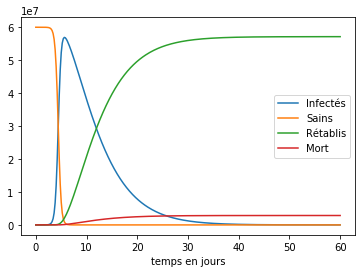

In [7]:
xo = np.array([20,0,6e7,0,0])

delta = 1/4    # temps d'apparition des symptomes (4j)
alpha = 6      # nombre de personnes rencontrées par jours
gamma = 0.6    # probabilité de contaminer une personne
lbd = 1/5      # temps de guérison (5j)
iota = 0.01    # taux de mortalité

t = np.linspace(0., 60., 300)
solution = odeint(model2, xo,t)
solution = solution.T

plt.plot(t,solution[0]+solution[1],t,solution[2],t,solution[3],t,solution[4])
plt.xlabel('temps en jours')
plt.legend(['Infectés','Sains','Rétablis','Mort'])

In [8]:
print('Nombre de morts estimé : '+ format(solution[4][-1], '0,.0f'))

Nombre de morts estimé : 2,857,004


Considérons qu'une partie de la population prend peur plus le nombre de morts et d'infectés augmente.

On peut donc moduler le nombres de rencontres par la fonction $1-\frac{1}{1+e^{-a(I_2(t)+M(T)-b)}}$

En gros plus il y a de morts ou d'infecté (malade) moins il y a de rencontres


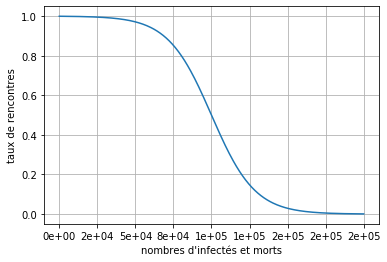

In [9]:
import matplotlib.ticker as ticker

pop =  np.linspace(0., 2e5, 300)
fct = 1-1/(1+np.exp(-7e-5*(pop-1e5)))

fig, ax = plt.subplots()
ax.plot(pop,fct)
plt.ylabel("taux de rencontres")
plt.xlabel("nombres d'infectés et morts")
plt.grid('on')

# Rewrite the y labels
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))

In [10]:
def model3(x,t) :
    #     | I1
    #     | I2
    # x = | S
    #     | R
    #     | M
    
    dx = np.empty((5,))
    proba = 1-1/(1+np.exp(-7e-5*(x[1]+x[4]-1e5)))
    
    p = 1/(x[0]+x[2]+x[3])
    dx[0] = proba*alpha*gamma*p*x[0]*x[2] - delta*x[0]
    dx[1] = delta*x[0] -lbd*x[1] -iota*x[1]
    dx[2] = -alpha*gamma*p*x[0]*x[2] 
    dx[3] = lbd*x[1]
    dx[4] = iota*x[1]
    
    return dx

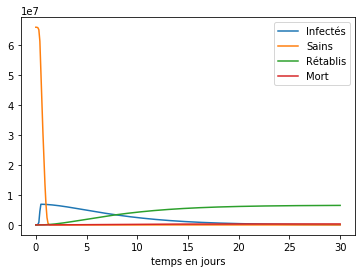

In [11]:
xo = np.array([4000,0,6.6e7,0,0])

delta = 1/4    # temps d'apparition des symptomes (4j)
alpha = 30      # nombre de personnes rencontrées par jours
gamma = 0.6    # probabilité de contaminer une personne
lbd = 1/5      # temps de guérison (5j)
iota = 0.01    # taux de mortalité

t = np.linspace(0., 30., 300)
solution = odeint(model3, xo,t)
solution = solution.T

plt.plot(t,solution[0]+solution[1],t,solution[2],t,solution[3],t,solution[4])
plt.xlabel('temps en jours')
plt.legend(['Infectés','Sains','Rétablis','Mort'])

In [12]:
print('Nombre de morts estimé : ' + format(solution[4][-1], '0,.0f'))

Nombre de morts estimé : 325,826


In [13]:
print('Nombre total d\'infectés : '+ format(solution[4][-1] + solution[3][-1], '0,.0f'))

Nombre total d'infectés : 6,842,347
